In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.4.0'

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [5]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [6]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [7]:
words[:10]

['',
 'shown it sooner but he lets it go on for months and then to call him',
 'who are they why are they here what do they want and when will all',
 'his hesitation and trying to arouse his former devotional feeling',
 'go go killed in battle where the best of russian men and russias',
 'youths officers and cadets who had galloped past him on their',
 'and salt and an icon of saint peter and saint paul asking permission',
 'nataly you know my love for my son i would do anything for his',
 'the other quite a new reflection of the society in which they had taken',
 'this is what i think austria has been made a fool of and she is not']

In [8]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [9]:
block_size = 5 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 5]), torch.int64, torch.Size([204978]), torch.int64)

In [11]:
emb_dim = 64
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[ 0.9679,  0.4782,  1.5618,  ...,  0.6617,  1.1884,  0.1148],
        [ 0.5514, -2.2804, -0.7135,  ..., -3.6065,  0.6592, -0.0764],
        [ 1.0029, -0.0146, -0.6445,  ..., -0.3635, -2.2193, -0.6284],
        ...,
        [-0.7538, -0.0101, -1.0042,  ..., -0.2626, -1.3306, -0.8650],
        [-0.4562, -1.7043,  0.3877,  ..., -0.0464,  0.5462,  0.1809],
        [ 0.3918,  1.2615,  0.0909,  ..., -0.4328, -0.8291, -0.2957]],
       requires_grad=True)

In [12]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.tanh(self.lin1(x))
        x = self.lin2(x)
        return x 
    


In [13]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 1024).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1027 14:40:42.068000 132972588926784 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/2313360188.py line 8 
W1027 14:40:42.068000 132972588926784 torch/_dynamo/convert_frame.py:1009] due to: 
W1027 14:40:42.068000 132972588926784 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1027 14:40:42.068000 132972588926784 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1027 14:40:42.068000 132972588926784 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1027 14:40:42.068000 132972588926784 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1027 14:40:42.068000 132972588926784 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1027 14:40:42.068000 132972588926784 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 groups absentmindedness bleed stimulate sukhtelen joyfully feeble gravely recalcitrant rulenot braver equality fussily mans brokendown shinshina unalterably able occasionally overcoat nuns foi insult affronts accident nearer arms unusual reports fulfill manservant frankly adorable wellbuilt reinforce scabbards lamp pleasantest apraksin tree shedding compared does sprung crews removing enemies possibilite moscovites distressful neutrality order convalescence dulled introduction foh reverence goodbye sisters attribute tenor unwilling semicircular intelligence appealing bivouacs collection fencing doesnt expert arrives cried beating matter yellowish semenov convient reinforcement academy archives nearest las dispatching serfsmade boulevards happens daybreak himhe invincibility flowed avoided embroidering recross respect zis misunderstanding clergy plunging deserted reply
 career dignitaries damp jacquot indifference lea submit strap diplomat reasoning begill pining dropped moreover polon

In [14]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 64])
_orig_mod.lin1.weight torch.Size([1024, 320])
_orig_mod.lin1.bias torch.Size([1024])
_orig_mod.lin2.weight torch.Size([11189, 1024])
_orig_mod.lin2.bias torch.Size([11189])


In [15]:
len(stoi)

11189

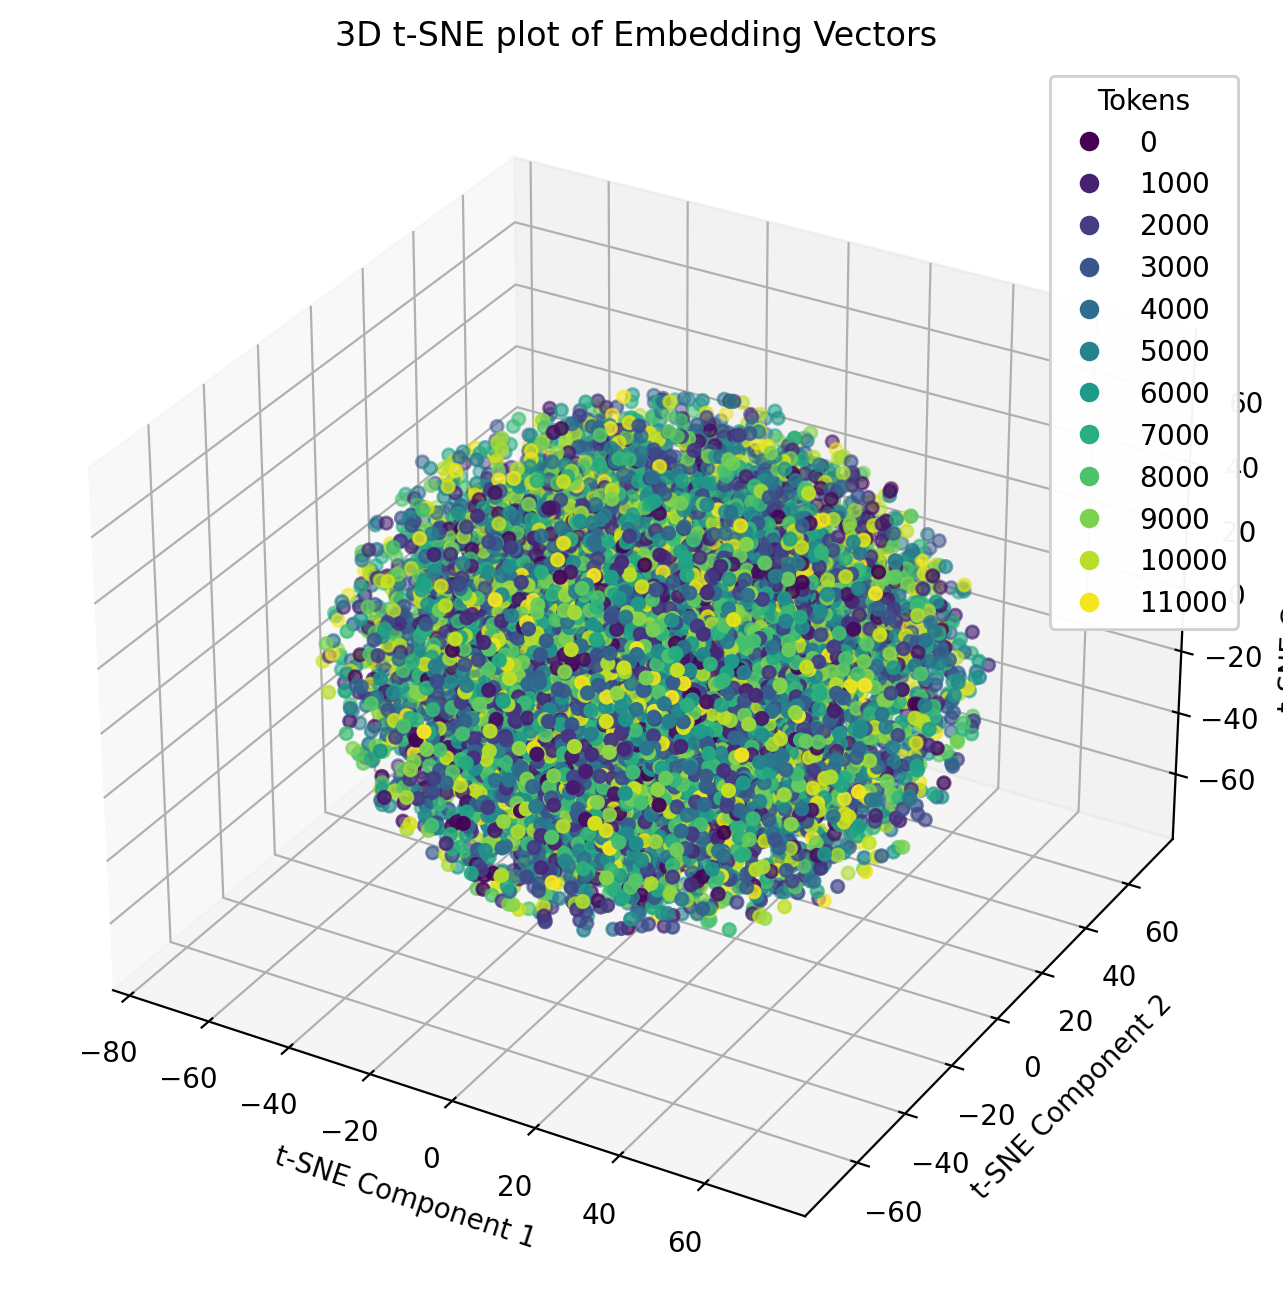

In [16]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [20]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(500):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 2.8456034660339355
Epoch 10, Loss: 2.7897214889526367
Epoch 20, Loss: 2.7681102752685547
Epoch 30, Loss: 2.7512102127075195
Epoch 40, Loss: 2.7363431453704834
Epoch 50, Loss: 2.7227437496185303
Epoch 60, Loss: 2.7101008892059326
Epoch 70, Loss: 2.698228120803833
Epoch 80, Loss: 2.687044382095337
Epoch 90, Loss: 2.6764955520629883
Epoch 100, Loss: 2.6665072441101074
Epoch 110, Loss: 2.6570465564727783
Epoch 120, Loss: 2.6480894088745117
Epoch 130, Loss: 2.6395840644836426
Epoch 140, Loss: 2.631488800048828
Epoch 160, Loss: 2.6164567470550537
Epoch 170, Loss: 2.609488010406494
Epoch 180, Loss: 2.6028637886047363
Epoch 190, Loss: 2.596558094024658
Epoch 200, Loss: 2.5905537605285645
Epoch 210, Loss: 2.5848255157470703
Epoch 220, Loss: 2.5793423652648926
Epoch 230, Loss: 2.5741047859191895
Epoch 240, Loss: 2.569089412689209
Epoch 250, Loss: 2.5642857551574707
Epoch 260, Loss: 2.559695243835449
Epoch 270, Loss: 2.555305004119873
Epoch 280, Loss: 2.5510807037353516
Epoch 290, 

In [18]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 sadness have ceased for the reasson how still i am all now you come to me prince andrew let leave the rostovs i know nothing more joined sources prince vasili in
 remained perhaps not like the fascination just but had twice seen on all night till of
 
 feeling to see prince dolgorukov who had felt boris
 particularly while there
 from salzeneck cheekbones and a third steps salute themselves dismounted with her vexation word
 well wont only just a friend he would have
 
 
 he was afraid on around him the pretty women


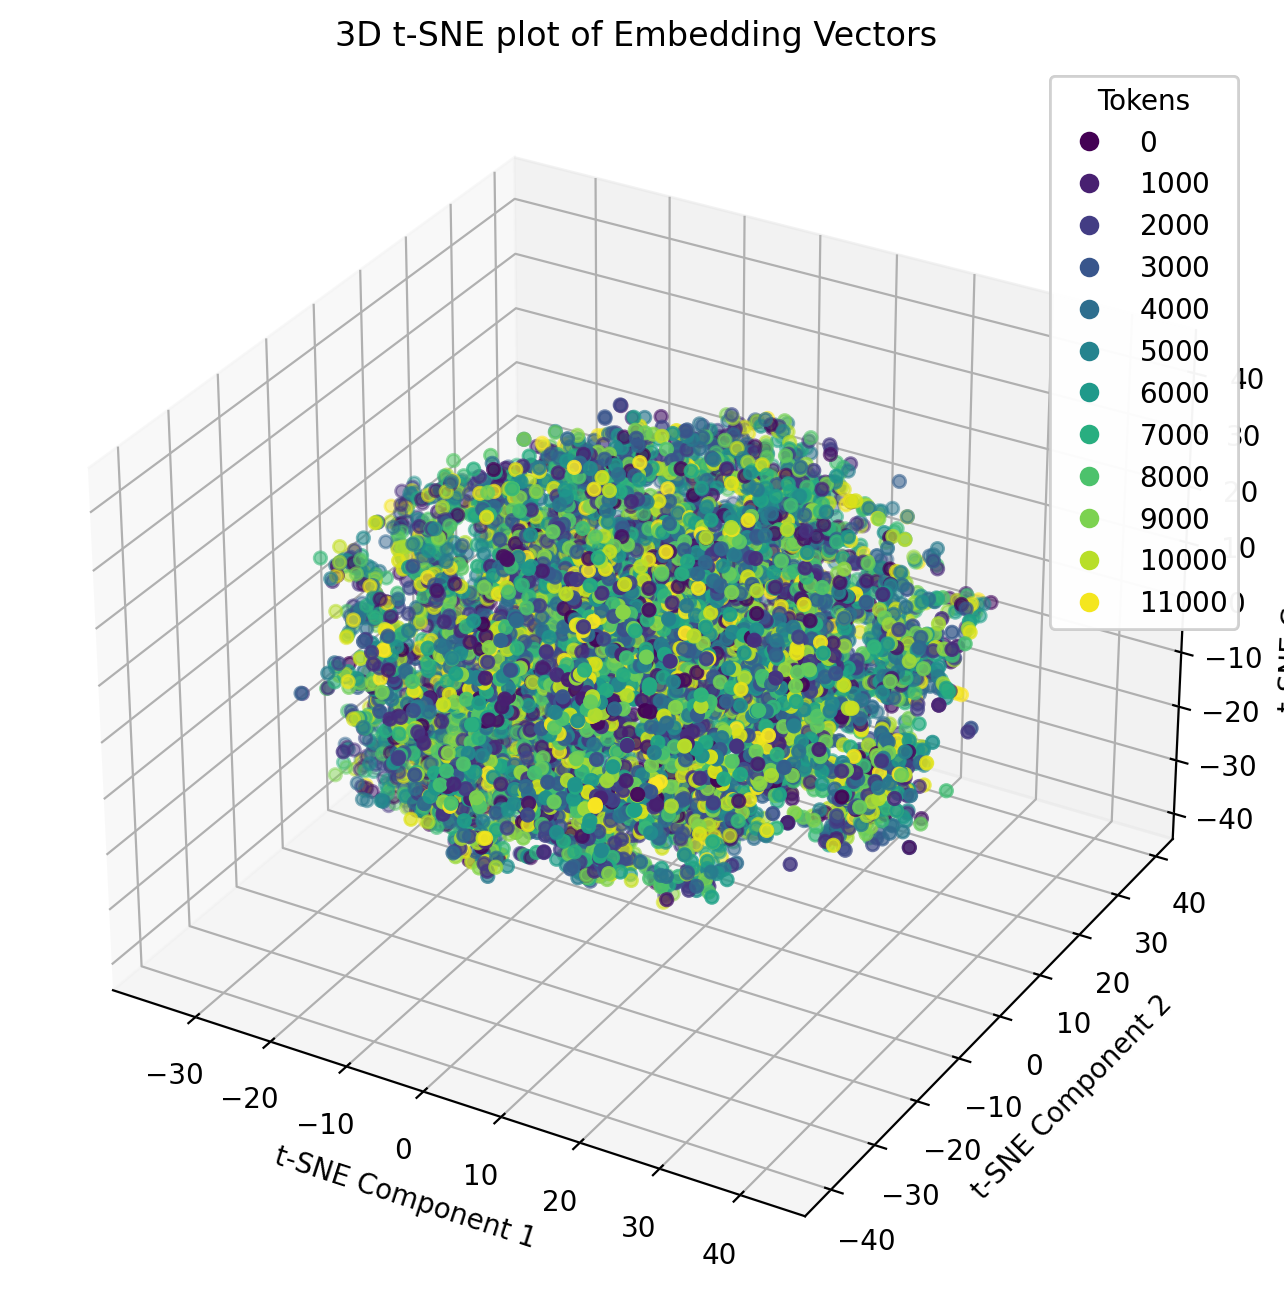

In [22]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [29]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_5_64_1024_t.pth")

In [26]:
model = model.to(device)